# Blind injection study 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# read data
data = pd.read_csv("data.txt", sep = ",")
data.columns = data.columns.str.strip()

In [3]:
data.head()

,x,y1,y2,y3
0,-10.00000,-27.835948,-1.204022,32.752084
1,-9.97998,-29.139783,-2.574528,31.335606
2,-9.95996,-28.501142,-2.001794,31.858014
3,-9.93994,-27.178927,-0.744721,33.060393
4,-9.91992,-27.492202,-1.122373,32.623676


In [78]:
len(data['x'])

1000

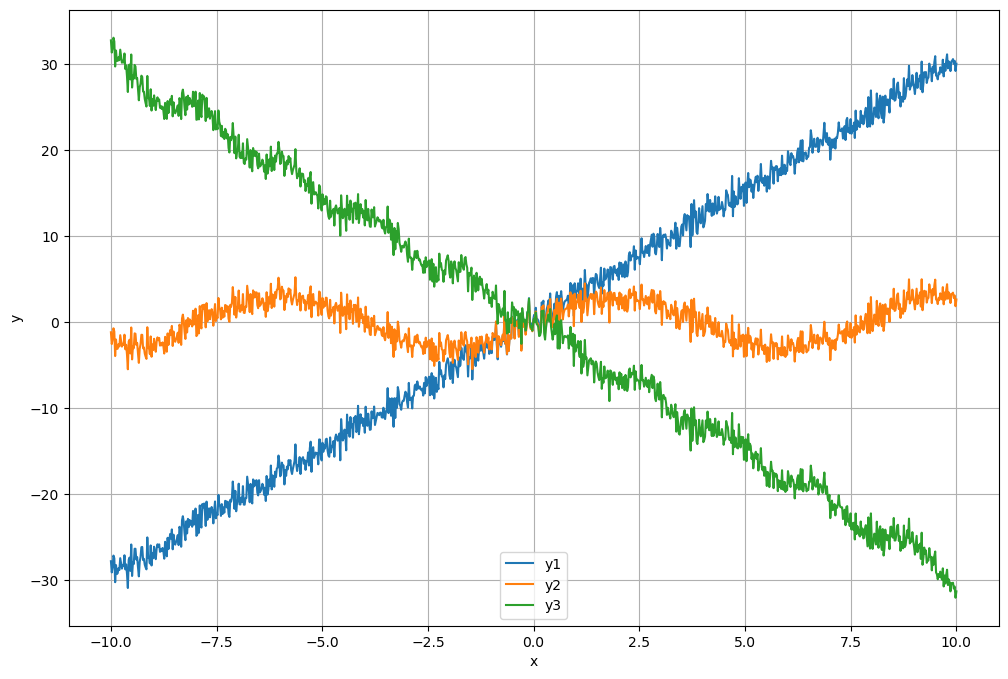

In [4]:
# plot data
plt.figure(figsize=(12, 8))
plt.plot(data['x'], data['y1'], label='y1')
plt.plot(data['x'], data['y2'], label='y2')
plt.plot(data['x'], data['y3'], label='y3')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

The statistical model is y ~ $N(f(x,\beta ),1)$ that each y is normally distributed with the mean of $f(x,\beta )$ and variance of 1. i.e., For i=,...,n,  $y_i  =f(x_i,\beta ) + e_i , e_i$ ~ N(0,1) 


## y1

It can be seen from the image of y1 that y1 has both a linear growth trend and an oscillation trend.
So we can first assume that the model of y1 is $y_1 = \beta_0 + \beta_1*x + \beta_2 sin(\omega *x) + e$

$\beta_0$ - intercept

$\beta_1$ - slope

$\beta_2$ - amplitude

$\omega$ - oscillation frequency

$e$ - Errors, $e$ ~ N(0,1)

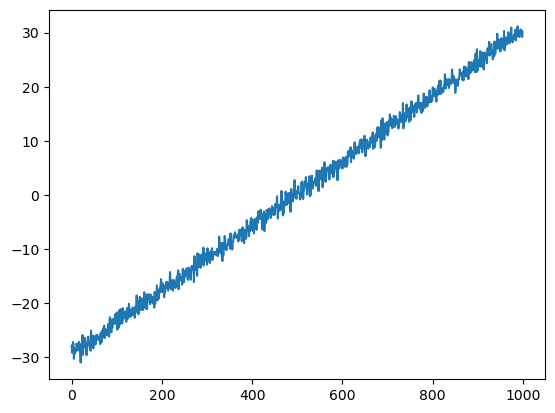

In [172]:
plt.plot(data['y1'])

In [ ]:
beta0=

In [130]:
def model(x, beta0, beta1, beta2, omega):
    return beta0 + beta1 * x + beta2 * np.sin(omega * x)


In [191]:
def log_likelihood(y_obs, y_pred, sigma=1):
    return -0.5 * np.sum(((y_obs - y_pred) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))


In [286]:
def prior(beta0, beta1, beta2, omega):
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10 and 0 < omega < 20:
        return 1
    else:
        return 0


In [287]:
def metropolis_hastings(y, x, iterations, initial_params, step_size):
    beta0, beta1, beta2, omega = initial_params
    current_log_prob = log_likelihood(y, model(x, beta0, beta1, beta2, omega)) + np.log(prior(beta0, beta1, beta2, omega))
    
    chain = np.empty((iterations, len(initial_params)))
    chain[0] = initial_params
    
    for i in range(1, iterations):
        beta0_prop, beta1_prop, beta2_prop, omega_prop = chain[i-1] + step_size * np.random.randn(4)
        prop_log_prob = log_likelihood(y, model(x, beta0_prop, beta1_prop, beta2_prop, omega_prop)) + np.log(prior(beta0_prop, beta1_prop, beta2_prop, omega_prop))
        
        # 计算接受概率，使用对数形式避免直接除法
        if prop_log_prob - current_log_prob > np.log(np.random.rand()):
            chain[i] = [beta0_prop, beta1_prop, beta2_prop, omega_prop]
            current_log_prob = prop_log_prob
        else:
            # 如果提议被拒绝，使用当前参数作为链中的下一个样本
            chain[i] = chain[i-1]
    
    return chain

In [288]:
#
initial_params = [0, 3, 1, 10]  
iterations = 10000  #
step_size = 0.01  

accepted = metropolis_hastings(data['y1'], data['x'], iterations, initial_params, step_size)




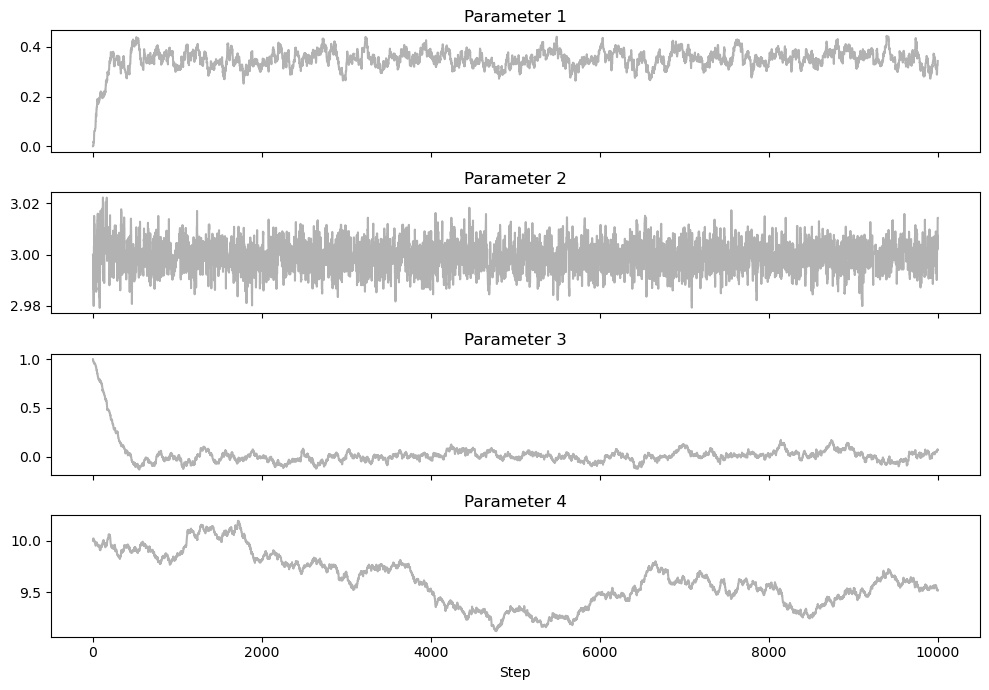

In [289]:
n_params = accepted.shape[1]

fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
for i in range(n_params):
    axes[i].plot(accepted[:, i], "k", alpha=0.3)
    axes[i].set_title(f'Parameter {i+1}')
axes[n_params-1].set_xlabel("Step")
plt.tight_layout()
plt.show()

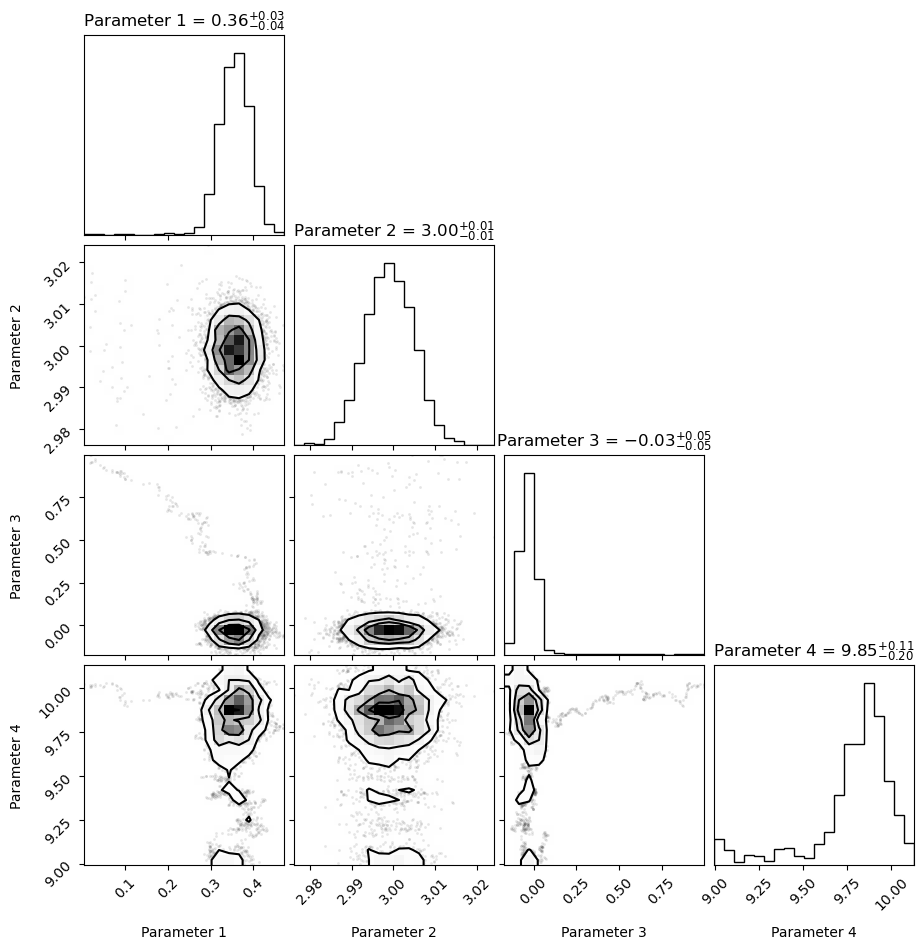

In [97]:
import corner


fig = corner.corner(accepted, labels=[f'Parameter {i+1}' for i in range(accepted.shape[1])], 
                    show_titles=True, title_kwargs={"fontsize": 12})

plt.show()


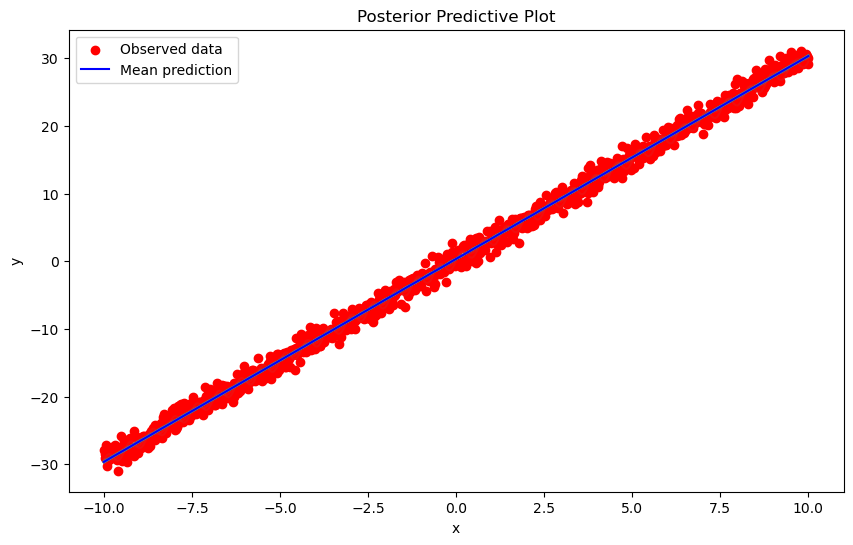

In [99]:

plt.figure(figsize=(10, 6))

plt.scatter(data['x'], data['y1'], color='r', label='Observed data')


for beta0, beta1, beta2, omega in accepted[np.random.randint(len(accepted), size=100)]:
    
    y_pred = model(data['x'], beta0, beta1, beta2, omega)
    plt.plot(data['x'], y_pred, color='grey', alpha=0.1)

y_pred_mean = np.mean([model(data['x'], *params) for params in accepted], axis=0)
plt.plot(data['x'], y_pred_mean, color='blue', label='Mean prediction')

plt.title('Posterior Predictive Plot')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [290]:
def run_mcmc(y, x, n_iterations, n_walkers, step_size, initial_params_range):
    # 存储所有walkers的链
    chains = np.empty((n_walkers, n_iterations, len(initial_params_range)))
    
    # 对每个walker初始化参数，并运行MCMC
    for w in range(n_walkers):
        # 从指定的范围中为每个参数随机选择一个初始值
        initial_params = [np.random.uniform(low, high) for low, high in initial_params_range]
        
        # 运行Metropolis-Hastings算法
        chain = metropolis_hastings(y, x, n_iterations, initial_params, step_size)
        
        # 将结果存储在chains数组中
        chains[w, :, :] = chain
    
    return chains

# 设置walkers的数量和初始参数范围
n_walkers = 10
initial_params_range = [(0, 1), (2,5), (0, 2), (5, 15)]  # 每个参数的(low, high)范围

# 运行MCMC
chains = run_mcmc(data['y1'], data['x'], 5000, n_walkers, 0.01, initial_params_range)

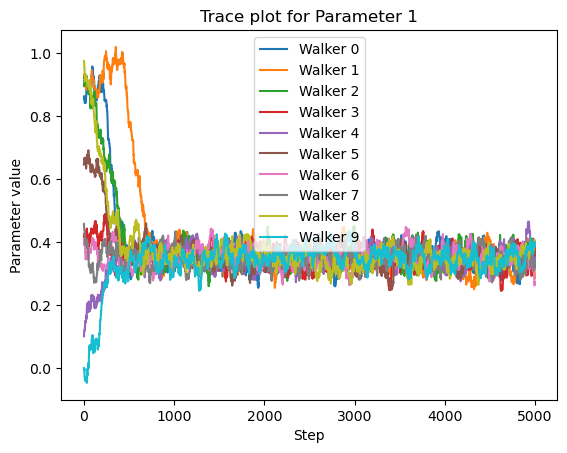

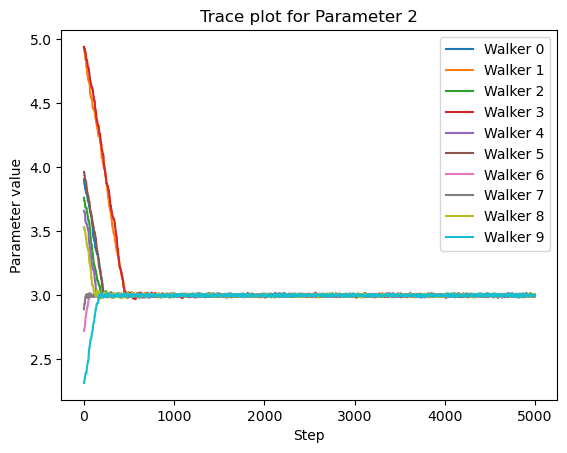

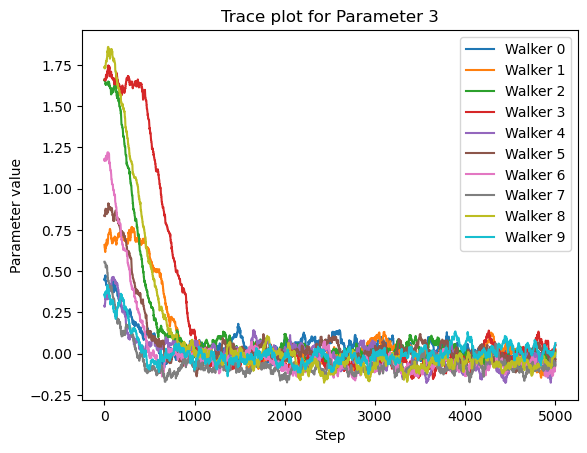

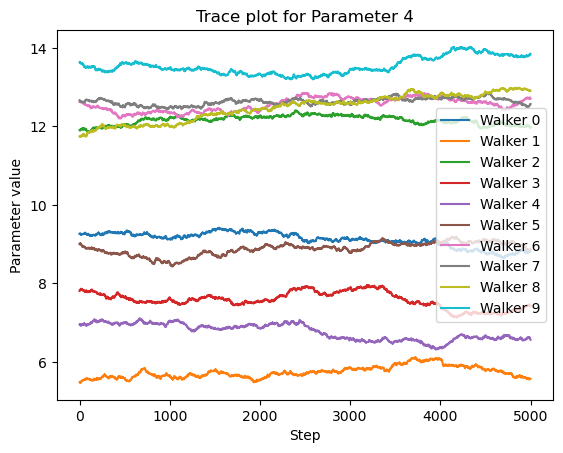

In [291]:

for id in range(4):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains[i, :, param_id], label=f'Walker {i}')
    plt.title(f'Trace plot for Parameter {param_id+1}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()


## y2

According to the observation, y2 has a large periodic oscillation mode and a small oscillation mode. So I assume the model conforms to the following pattern:
$y_2 = \beta_0 + \beta_1 sin(\omega_1 x) + \beta_2 sin(\omega_2 x) + e$

In [62]:
def model_y2(x,params):
    beta0, beta1, omega1, beta2, omega2 = params
    return beta0 + beta1 * np.cos(omega1 * x) + beta2 * np.cos(omega2 * x)

In [63]:
def log_likelihood_y2(y_obs, y_pred):
    log_l = np.sum(norm.logpdf(y_obs - y_pred, loc=0, scale=1))
    return log_l

In [64]:
def log_prior_y2(params):
    beta0, beta1, omega1, beta2, omega2 = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10 and -10 < omega1 < 10 and -50 < omega2 < 50:
        return 0
    else:
        return -np.inf

In [65]:
def metropolis_hastings_y2(y, x, n_iterations, initial_params, step_sizes):
    n_params = len(initial_params)
    current_params = initial_params
    current_log_prob = log_likelihood_y2(y, model_y2(x, current_params)) + log_prior_y2(current_params)
    
    # 注意这里使用np.empty代替np.zeros，与mh1保持一致
    chain = np.empty((n_iterations, n_params))
    chain[0] = current_params  # 设置初始参数
    n_accepted = 0
    
    for i in range(1, n_iterations):  # 开始循环时i为1，因为已经设置了初始参数
        # 生成提议参数，这里直接用数组广播而非列表推导式
        proposed_params = current_params + np.random.normal(0, step_sizes, n_params)
        proposed_log_prob = log_likelihood_y2(y, model_y2(x, proposed_params)) + log_prior_y2(proposed_params)
        
        # 接受或拒绝提议，这里使用与mh1相同的逻辑
        if proposed_log_prob - current_log_prob > np.log(np.random.rand()):
            current_params = proposed_params
            current_log_prob = proposed_log_prob
            n_accepted += 1
        # 将当前参数集添加到链中，无论提议是否被接受
        chain[i] = current_params
    
    acceptance_rate = n_accepted / (n_iterations - 1)  # 减1因为初始参数不计入接受率
    return chain, acceptance_rate


In [26]:
n_iterations = 20000
initial_params = [0, 1, 1, 1, 10]  # 适当的初始参数
step_sizes = [0.01/2, 0.01/2, 0.2/2, 0.01/2, 0.2/2]  # 每个参数的步长

chain, acceptance_rate= metropolis_hastings_y2(data['y2'], data['x'], n_iterations, initial_params, step_sizes)

In [27]:
chain

array([[ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+01],
       [ 1.45936393e-03,  1.00015363e+00,  1.00027302e+00,
         1.00060907e+00,  1.01470990e+01],
       [ 1.45936393e-03,  1.00015363e+00,  1.00027302e+00,
         1.00060907e+00,  1.01470990e+01],
       ...,
       [-6.78826327e-02,  4.41235645e-01,  8.42999471e-01,
         4.63281043e-01,  1.02942254e+01],
       [-6.78826327e-02,  4.41235645e-01,  8.42999471e-01,
         4.63281043e-01,  1.02942254e+01],
       [-6.78826327e-02,  4.41235645e-01,  8.42999471e-01,
         4.63281043e-01,  1.02942254e+01]])

In [28]:
acceptance_rate

0.19560978048902444

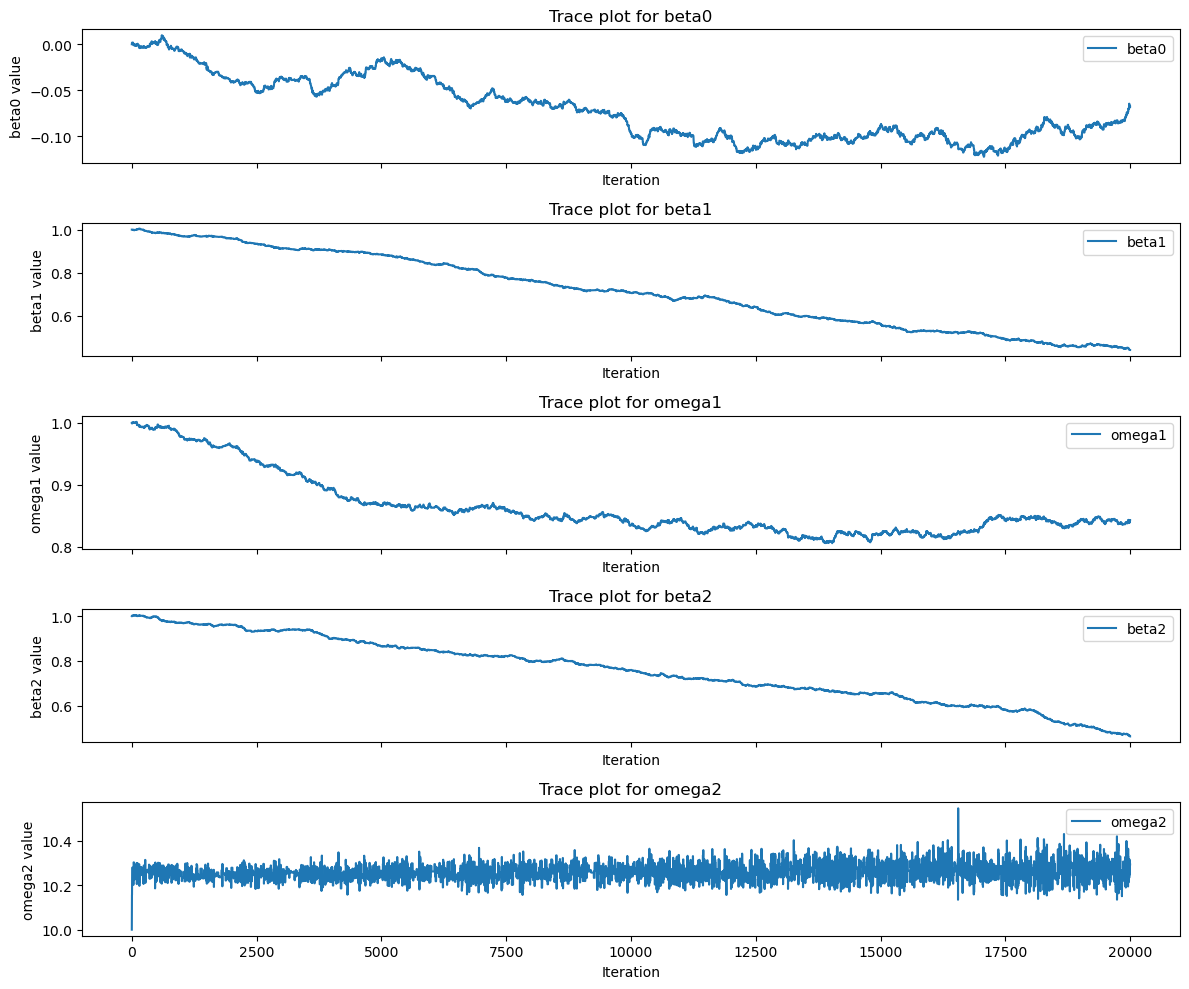

In [29]:
def plot_trace(chain, param_names):
    n_iterations, n_params = chain.shape
    
    fig, axes = plt.subplots(n_params, figsize=(12, 2 * n_params), sharex=True)
    
    for i in range(n_params):
        ax = axes[i]
        ax.plot(chain[:, i], label=f'{param_names[i]}')
        ax.set_title(f'Trace plot for {param_names[i]}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel(f'{param_names[i]} value')
        ax.legend()
    
    fig.tight_layout()
    plt.show()

# Define your parameter names based on your model
param_names = ['beta0', 'beta1', 'omega1', 'beta2', 'omega2']

# Call the function with the chain from your MCMC algorithm
plot_trace(chain, param_names)

In [66]:
def run_mcmc_y2(y,x , n_iterations, n_walkers, step_size, initial_params_range):
    chains = np.empty((n_walkers, n_iterations, len(initial_params_range)))
    
    for w in range(n_walkers):
        init_params = [np.random.uniform(low, high) for low, high in initial_params_range]
        
        chain, accept= metropolis_hastings_y2(y, x, n_iterations, init_params, step_sizes)
        
        chains[w, :, :] = chain
        
    return chains

n_walkers = 10
initial_params_range = [(-1, 1), (-1,1), (0, 10), (0,3), (0, 30)]
step_sizes = [0.01/2, 0.01/2, 0.2/2, 0.01/2, 0.2/2]

chains = run_mcmc_y2(data['y2'], data['x'], 20000, n_walkers, step_sizes, initial_params_range)

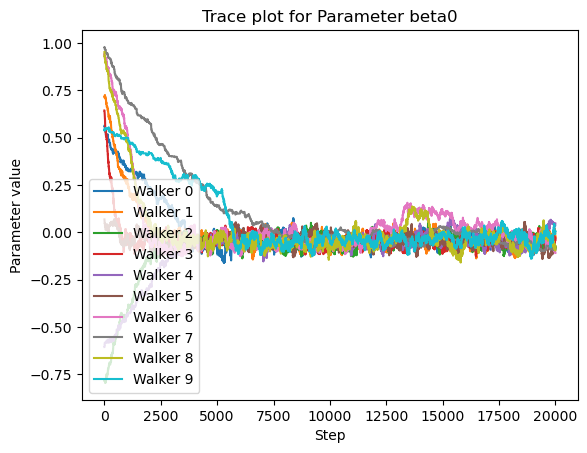

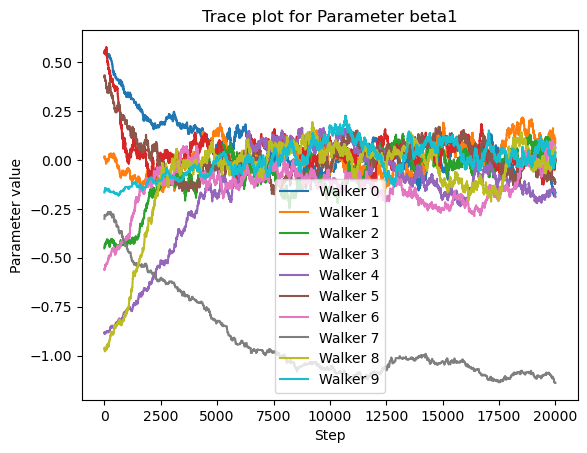

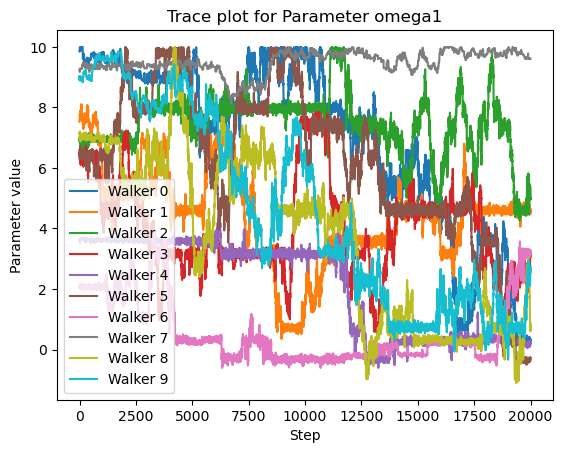

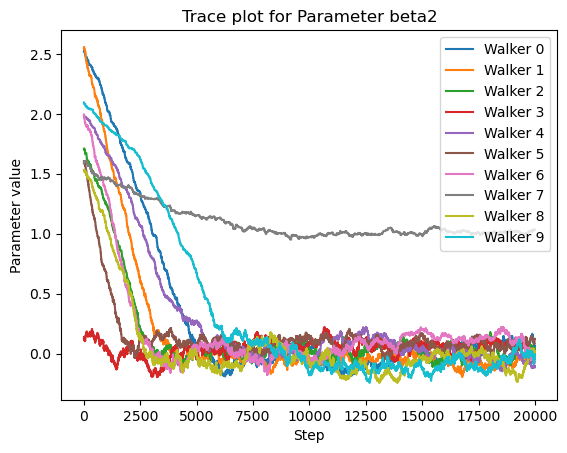

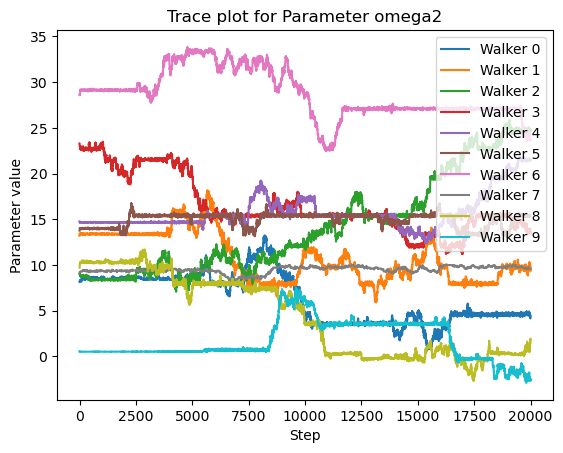

In [67]:
param_names = ['beta0', 'beta1', 'omega1', 'beta2', 'omega2']
for id in range(5):
    param_id = id  
    for i in range(n_walkers):
        plt.plot(chains[i, :, param_id], label=f'Walker {i}')
    plt.title(f'Trace plot for Parameter {param_names[param_id]}')
    plt.xlabel('Step')
    plt.ylabel('Parameter value')
    plt.legend()
    plt.show()

In [165]:
import emcee

def model_y2(x,params):
    beta0, beta1, omega1, beta2, omega2 = params
    return beta0 + beta1 * np.sin(omega1 * x) + beta2 * np.sin(omega2 * x)

def log_likelihood_y2(params, x, y):
    beta0, beta1, omega1, beta2, omega2 = params
    model = beta0 + beta1 * np.sin(omega1 * x) + beta2 * np.sin(omega2 * x)
    log_l = np.sum(norm.logpdf(y - model, loc=0, scale=1))
    return log_l

# 对数先验函数
def log_prior(params):
    beta0, beta1, omega1, beta2, omega2 = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10 and 0 < omega1 < 10 and 0 < omega2 < 50:
        return 0.0
    return -np.inf

# 总的对数后验概率函数
def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_y2(params, x, y)

# emcee的参数设置
nwalkers = 32
ndim = 5
pos = [np.array([0, 1, 1, 1, 10]) + 0.1 * np.random.randn(ndim) for i in range(nwalkers)]

# 设置sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data['x'], data['y2']))

# 执行MCMC采样，这里做一个较小的迭代次数示例
sampler.run_mcmc(pos, 5000, progress=True)

# 绘制迹线图
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["beta0", "beta1", "omega1", "beta2", "omega2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step number")
plt.show()


  2%|▋                                        | 85/5000 [00:02<02:12, 37.17it/s]Traceback (most recent call last):
  File "/Users/yangyukun/anaconda3/envs/pymc_env/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/nd/djf_sjzj0693p1d1z49j8js40000gn/T/ipykernel_22738/4186535546.py", line 25, in log_probability
    return lp + log_likelihood_y2(params, x, y)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/nd/djf_sjzj0693p1d1z49j8js40000gn/T/ipykernel_22738/4186535546.py", line 9, in log_likelihood_y2
    model = beta0 + beta1 * np.sin(omega1 * x) + beta2 * np.sin(omega2 * x)
                    ~~~~~~^~~~~~~~~~~~~~~~~~~~
  File "/Users/yangyukun/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pandas/core/generic.py", line 2168, in __array_ufunc__
    return arraylike.array_ufunc(self, ufunc, method, *inputs, **kwargs)
         

emcee: Exception while calling your likelihood function:
  params: [-0.03186966  2.27613072  0.78379754  0.35409366 10.85800864]
  args: (0     -10.00000
1      -9.97998
2      -9.95996
3      -9.93994
4      -9.91992
         ...   
995     9.91992
996     9.93994
997     9.95996
998     9.97998
999    10.00000
Name: x, Length: 1000, dtype: float64, 0     -1.204022
1     -2.574528
2     -2.001794
3     -0.744721
4     -1.122373
         ...   
995    3.402802
996    2.787215
997    3.074724
998    1.827074
999    2.609961
Name: y2, Length: 1000, dtype: float64)
  kwargs: {}
  exception:


KeyboardInterrupt: 

## y3

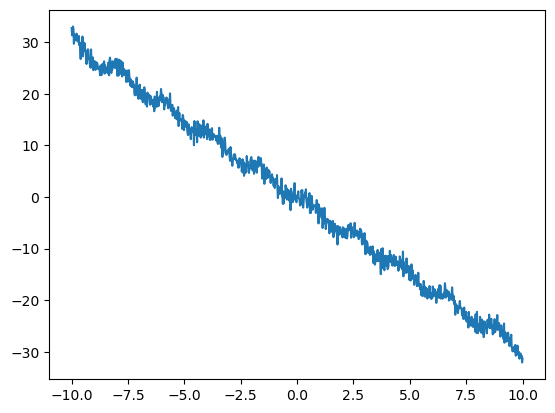

In [68]:
plt.plot(data['x'], data['y3'], label='y3')

$y = \beta_0 + \beta_1 x + \beta_2 sin(\omega_1 x) + \beta_3 sin(\omega_2 x) + e$

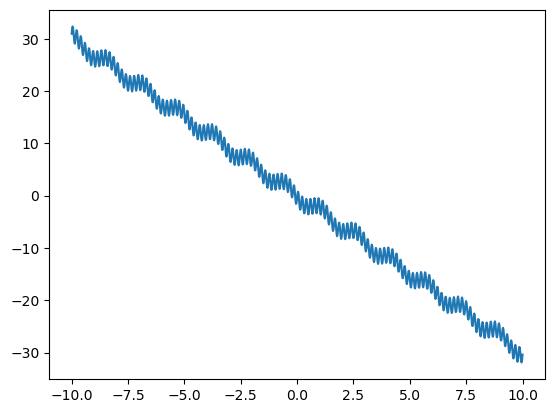

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# 定义x的范围
x = np.linspace(-10, 10, 1000)

# 定义新的模型参数，以适应指定的y模型形式
# y = β0 + β1x + β2sin(ω1x) + β3sin(ω2x) + e
# 其中e是误差项，这里忽略不计

# 模型参数
β0 = 0  # y轴截距
β1 = -3  # 确保是下降趋势
β2 = 1.5   # 第一个正弦波的振幅

ω1 = 11 * np.pi  # 第一个正弦波的频率

β3 = 1   # 第二个正弦波的振幅，较小的频繁震荡
ω2 = 4   # 第二个正弦波的频率，更高频率的震荡
phi = 2
# 生成y值
y_complex = β0 + β1 * x + β2 * np.sin(ω1 * x) + β3 * np.cos(ω2 * x + phi) 
# y_complex = β0 + β1 * x + β2 * np.sin(ω1 * x) 
plt.plot(x,y_complex)


In [144]:
def model_y3(x, params):
    beta0, beta1, beta2, beta3, omega1, omega2, phi = params
    return beta0 + beta1 * x + beta2 * np.sin(omega1 * x) + beta3 * np.cos(omega2 * x + phi)

In [145]:
def log_likelihood_y3(y_obs, y_pred):
    log_l = np.sum(norm.logpdf(y_obs - y_pred, loc=0, scale=1))
    return log_l

In [146]:
def log_prior_y3(params):
    beta0, beta1, beta2, beta3, omega1, omega2, phi = params
    if -10 < beta0 < 10 and -10 < beta1 < 10 and -10 < beta2 < 10 and -20*np.pi < omega1 < 20*np.pi and -10 < omega2 < 10 and -10 < phi < 10:
        return 0
    else:
        return -np.inf

In [147]:
def metropolis_hastings_y3(y, x, n_iterations, initial_params_y3, step_sizes_y3):
    n_params = len(initial_params_y3)
    current_params = initial_params_y3
    current_log_prob = log_likelihood_y3(y, model_y3(x, current_params)) + log_prior_y3(current_params)
    

    chain = np.empty((n_iterations, n_params))
    chain[0] = current_params  # 设置初始参数
    n_accepted = 0
    
    for i in range(1, n_iterations):  
        # 生成提议参数，这里直接用数组广播而非列表推导式
        proposed_params = current_params + np.random.normal(0, step_sizes_y3, n_params)
        proposed_log_prob = log_likelihood_y3(y, model_y3(x, proposed_params)) + log_prior_y3(proposed_params)
        
        # 接受或拒绝提议，这里使用与mh1相同的逻辑
        if proposed_log_prob - current_log_prob > np.log(np.random.rand()):
            current_params = proposed_params
            current_log_prob = proposed_log_prob
            n_accepted += 1
        # 将当前参数集添加到链中，无论提议是否被接受
        chain[i] = current_params
    
    acceptance_rate = n_accepted / (n_iterations - 1)  # 减1因为初始参数不计入接受率
    return chain, acceptance_rate

In [161]:
n_iterations = 20000
initial_params_y3 = [1, -3, 1.5, 1, 10 * np.pi, 4, 2]  
step_sizes_y3 = [0.01, 0.01, 0.01, 0.01, 0.3, 0.05, 0.01]  

chain, acceptance_rate= metropolis_hastings_y3(data['y3'], data['x'], n_iterations, initial_params_y3, step_sizes_y3)

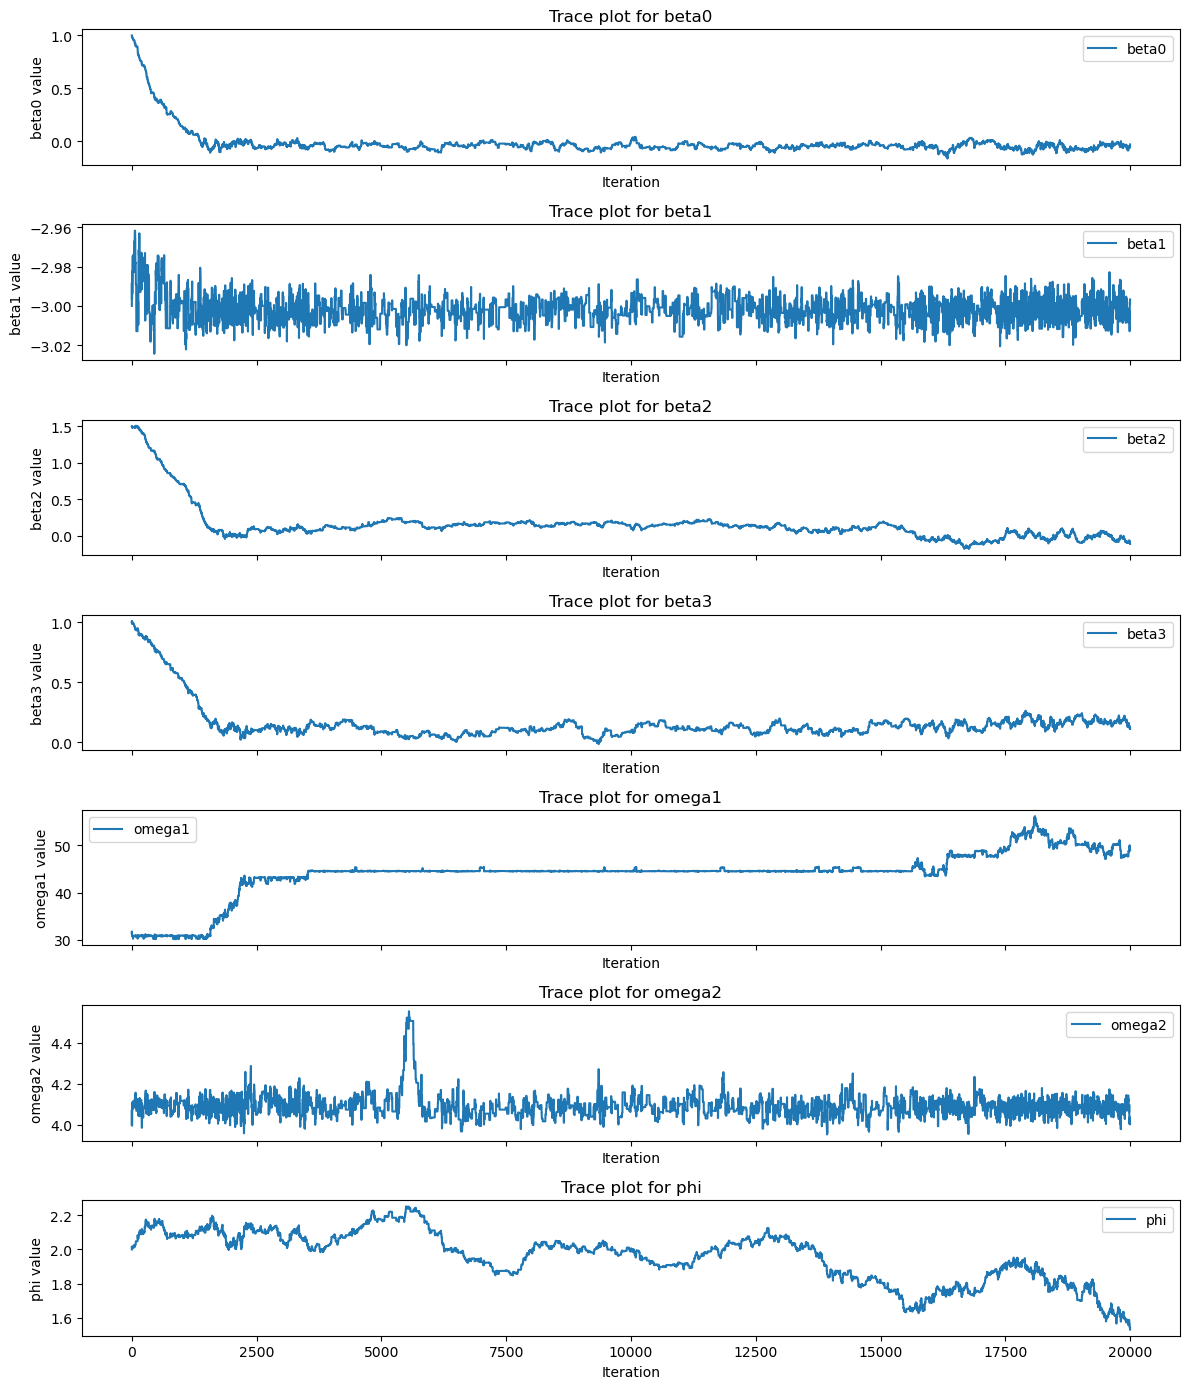

In [162]:
# Define your parameter names based on your model
param_names_y3 = ['beta0', 'beta1', 'beta2', 'beta3', 'omega1', 'omega2', 'phi']

# Call the function with the chain from your MCMC algorithm
plot_trace(chain, param_names_y3)

100%|█████████████████████████████████████| 10000/10000 [03:51<00:00, 43.26it/s]


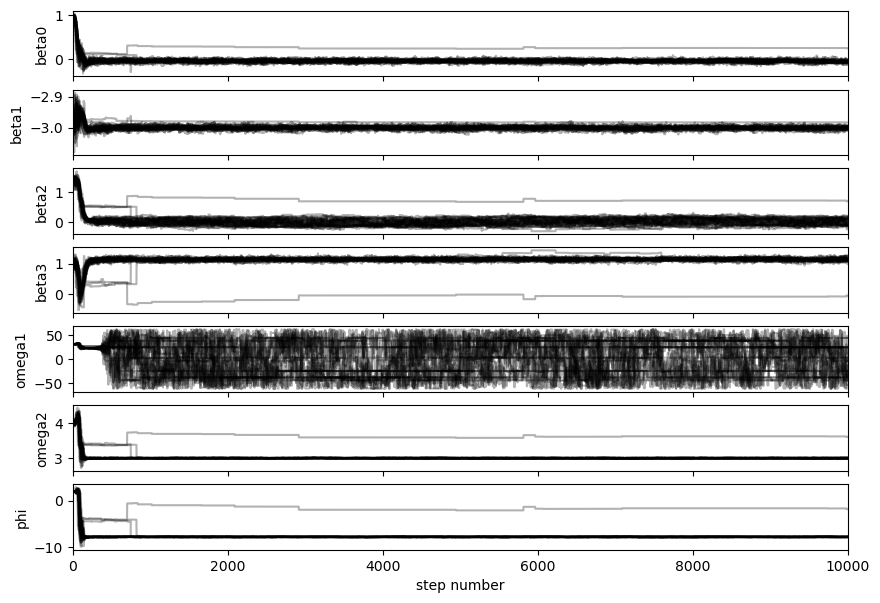

In [171]:


def log_probability_y3(params, x, y):
    lp = log_prior_y3(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_y3(y, model_y3(x, params))

# emcee的参数设置
nwalkers = 32
ndim = 7
pos = [np.array([1, -3, 1.5, 1, 10 * np.pi, 4, 2]) + 0.01 * np.random.randn(ndim) for i in range(nwalkers)]

# 设置sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_y3, args=(data['x'], data['y3']))


sampler.run_mcmc(pos, 10000, progress=True)

# 绘制迹线图
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_names_y3[i])
axes[-1].set_xlabel("step number")
plt.show()